# Обучение базовой модели логистической регрессии

In [0]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir('/content/drive/Shared drives/Кредитные риски')

In [0]:
from CreditRisks.metrics_library.Metrics import *
from CreditRisks.metrics_library.rosstat_utils import *

In [0]:
DIR_OUT='ReadyModels/SGD_final/'

## Считывание данных

In [0]:
df = pd.read_csv('Датасеты/revision_003/companies_ready_train.csv', dtype=RESULT_DTYPES)
y_train = df['target']
X_train = df.drop(columns=['inn', 'year_-1', 'year_0', 'target'])
df.head()

In [0]:
df1 = pd.read_csv('Датасеты/revision_003/companies_ready_test.csv', dtype=RESULT_DTYPES)
y_test = df1['target']
X_test = df1.drop(columns=['inn', 'year_-1', 'year_0', 'target'])
df1.head()

## Предобработка данных

### Добавление новых признаков

In [0]:
methodCols = ['financialDebt', 'CreditLeverage', 'FinancialIndependence', 'DebtBurden', 'CoverageDebtWithAccumulatedProfit', 
              'ReturnAssetsNetProfit', 'ReturnAssetsOperatingProfit', 'OperatingMargin', 'NetProfitMargin',
              'LiabilityCoverageOperatingProfit', 'OperatingProfitFinancialDebtRatio', 'FinancialDebtRevenueRatio',
              'CurrentLiquidity', 'QuickLiquidity', 'InstantLiquidity', 'LevelOfOperatingAssets', 'turnoverDebtorDebt',
              'turnoverReserves', 'turnoverCreditDebt', 'FinancialCycle', 'AssetTurnover']

In [0]:
def addFeatures(X:pd.Series)->pd.Series:
    X['financialDebt'] = X['year_0_15003'] + X['year_0_14003'] + X['year_0_12503']
    financialDebt = X['financialDebt'] 
    X['CreditLeverage'] = X['year_0_13003'] / X['year_0_15003'] 
    X['FinancialIndependence'] = X['year_0_13003'] / X['year_0_16003']
    X['DebtBurden'] = financialDebt / X['year_0_16003']
    X['CoverageDebtWithAccumulatedProfit'] = X['year_0_13003'] / financialDebt
    X['ReturnAssetsNetProfit'] = X['year_0_24003'] / X['year_0_16003']
    X['ReturnAssetsOperatingProfit'] = X['year_0_22003'] / X['year_0_16003']
    X['OperatingMargin'] = X['year_0_22003'] / pd.concat([X['year_0_21103'], financialDebt], axis=1).max(axis=1)
    X['NetProfitMargin'] = X['year_0_24003'] / pd.concat([X['year_0_21103'], financialDebt], axis=1).max(axis=1) # impotant
    X['LiabilityCoverageOperatingProfit'] = X['year_0_22003'] / (X['year_0_14003'] + X['year_0_15003'])
    X['OperatingProfitFinancialDebtRatio'] = X['year_0_22003'] / financialDebt
    X['FinancialDebtRevenueRatio'] = financialDebt / X['year_0_21103'] # impotant
    X['CurrentLiquidity'] = X['year_0_12003'] / X['year_0_15003']
    X['QuickLiquidity'] = (X['year_0_12003'] - X['year_0_12103']) / X['year_0_15003']
    X['InstantLiquidity'] = X['year_0_12503'] / X['year_0_15003'] # impotant
    X['LevelOfOperatingAssets'] = (X['year_0_12103'] + X['year_0_12303'] - X['year_0_15203']) / X['year_0_21103']
    X['turnoverDebtorDebt'] = 365 * (X['year_0_12303'] + X['year_0_12304']) / (2 * X['year_0_21103'])
    X['turnoverReserves'] = 365 * (X['year_0_12103'] + X['year_0_12104']) / (2 * X['year_0_21103'])
    X['turnoverCreditDebt'] = 365 * (X['year_0_15203'] + X['year_0_15204']) / (2 * X['year_0_21103'])
    X['FinancialCycle'] = X['turnoverDebtorDebt'] + X['turnoverReserves'] - X['turnoverCreditDebt']
    X['AssetTurnover'] = X['year_0_21103'] / X['year_0_16003']
    for col in methodCols:
        m = X.loc[X[col] != np.inf, col].max()
        X[col].replace(np.inf,m,inplace=True)
        _m = X.loc[X[col] != -np.inf, col].min()
        X[col].replace(-np.inf,_m,inplace=True)
        X[col].replace(np.nan,0,inplace=True)
    return X

In [0]:
X_train = addFeatures(X_train)
X_test = addFeatures(X_test)

### Стандартизация, винзоризация и выброс категориальных признаков

In [0]:
class Winsorizator():
    def __init__(self, left, right):
        assert 0 <= left <= 1 and 0 <= right <= 1
        self.left = left
        self.right = right
        self.data = None
    def fit(self, X:pd.DataFrame):
        self.data = X.quantile([self.left, self.right], axis=0)
    
    def transform(self, X:pd.DataFrame):
        X.clip(self.data.iloc[0], self.data.iloc[1], axis='columns', inplace=True)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [0]:
categorical_all = ['region','year_-1_okopf', 'year_-1_okfs', 'year_-1_okved', 'year_-1_type', 
                   'year_0_okopf', 'year_0_okfs', 'year_0_okved', 'year_0_type']
sc = StandardScaler()
winz = Winsorizator(0.3, 0.7)

In [0]:
X_train_1 = X_train.drop(columns=categorical_all).astype(np.float32)
winz.fit_transform(X_train_1)
X_train_1 = pd.DataFrame(sc.fit_transform(X_train_1), columns=X_train_1.columns, index=X_train_1.index)

In [0]:
X_test_1 = X_test.drop(columns=categorical_all).astype(np.float32)
winz.transform(X_test_1)
X_test_1 = pd.DataFrame(sc.transform(X_test_1), columns=X_test_1.columns, index=X_test_1.index)

In [0]:
with open(f'{DIR_OUT}StandardScaler.pkl','wb') as f:
    pickle.dump(sc, f)
with open(f'{DIR_OUT}Winsorizator.pkl','wb') as f:
    pickle.dump(winz, f)

## Обучение

In [0]:
lr = SGDClassifier(random_state=42, loss='log', verbose=1, max_iter=1000).fit(X_train_1, y_train)

-- Epoch 1
Norm: 2.53, NNZs: 117, Bias: -0.732345, T: 1029583, Avg. loss: 1.646674
Total training time: 2.19 seconds.
-- Epoch 2
Norm: 2.30, NNZs: 117, Bias: -0.819714, T: 2059166, Avg. loss: 0.591816
Total training time: 4.36 seconds.
-- Epoch 3
Norm: 2.27, NNZs: 117, Bias: -0.892477, T: 3088749, Avg. loss: 0.573912
Total training time: 6.51 seconds.
-- Epoch 4
Norm: 2.23, NNZs: 117, Bias: -0.743486, T: 4118332, Avg. loss: 0.567067
Total training time: 8.66 seconds.
-- Epoch 5
Norm: 2.22, NNZs: 117, Bias: -0.782168, T: 5147915, Avg. loss: 0.563339
Total training time: 10.84 seconds.
-- Epoch 6
Norm: 2.21, NNZs: 117, Bias: -0.790862, T: 6177498, Avg. loss: 0.561159
Total training time: 13.03 seconds.
-- Epoch 7
Norm: 2.20, NNZs: 117, Bias: -0.803704, T: 7207081, Avg. loss: 0.559675
Total training time: 15.19 seconds.
-- Epoch 8
Norm: 2.19, NNZs: 117, Bias: -0.807445, T: 8236664, Avg. loss: 0.558584
Total training time: 17.35 seconds.
-- Epoch 9
Norm: 2.19, NNZs: 117, Bias: -0.744681, T

In [0]:
with open(f'{DIR_OUT}SGD_model.pkl','wb') as f:
    pickle.dump(lr, f)

## Результаты

In [0]:
predict = lr.predict_proba(X_test_1)[:,1]

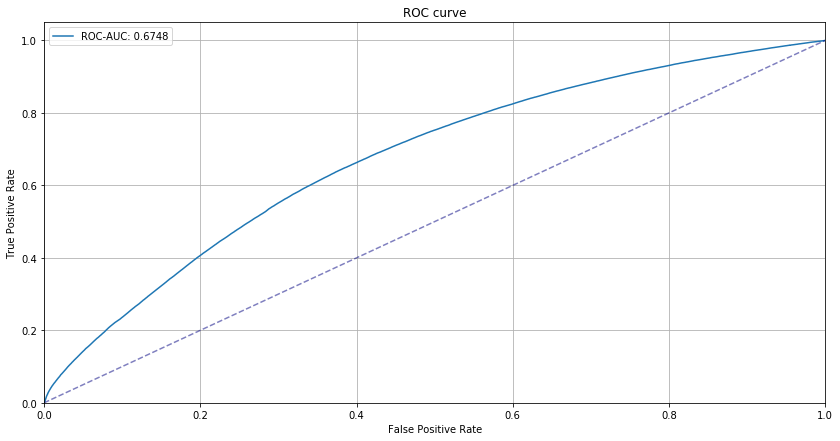

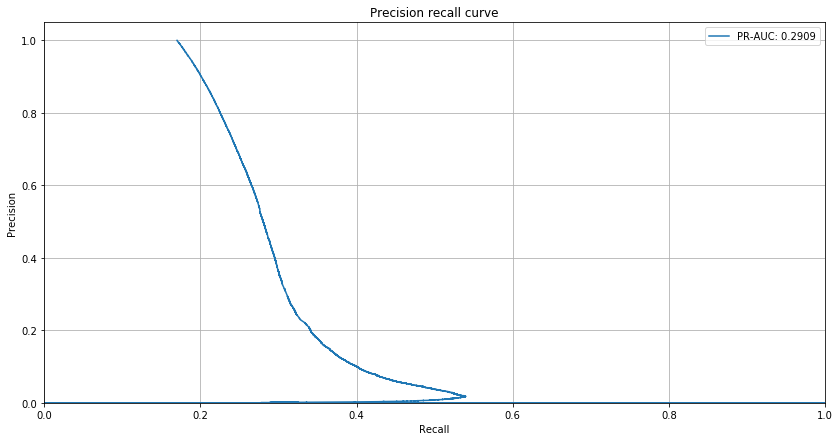

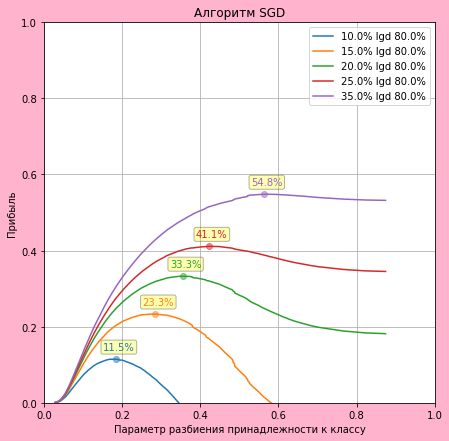

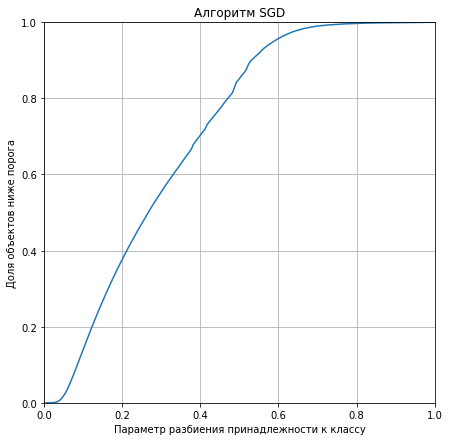

In [0]:
import CreditRisks.metrics_library.profits as metric
plt_roc(y_test,  predict)
plt_pr(y_test,  predict)
metric.plt_profit_2_experimental(y_test,  predict, percent_space=[0.10, 0.15, 0.20, 0.25, 0.35], title='Алгоритм SGD')
metric.plt_popularity(predict, title='Алгоритм SGD')